# Dogs vs. Cats

dataset on kaggle https://www.kaggle.com/tongpython/cat-and-dog

required modules

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import h5py
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

In [2]:
BASE_PATH = os.getenv('HOME') + '/Downloads/dogs-vs-cats'
training_path = os.path.join(BASE_PATH, 'training_set')
test_path = os.path.join(BASE_PATH, 'test_set')

print("# cats images in trainig set: ", len(os.listdir(os.path.join(training_path, 'cats'))))
print("# dogs images in trainig set: ", len(os.listdir(os.path.join(training_path, 'dogs'))))
print("# cats images in test set: ", len(os.listdir(os.path.join(test_path, 'cats'))))
print("# dogs images in test set: ", len(os.listdir(os.path.join(test_path, 'dogs'))))

# cats images in trainig set:  4000
# dogs images in trainig set:  4000
# cats images in test set:  1000
# dogs images in test set:  1000


Generate batches of tensor image data

In [3]:
data_generator = ImageDataGenerator(rescale = 1./255, zoom_range = 0.0) 

In [4]:
IMAGE_SIZE = 224
batch_size = 8
training_data = data_generator.flow_from_directory(directory = training_path,
                                                  target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                  batch_size = batch_size,
                                                  class_mode  = 'binary')

testing_data = data_generator.flow_from_directory(directory = test_path,
                                                  target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                  batch_size = batch_size,
                                                  class_mode  = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Get a batch by iterator

In [5]:
image_batch, label_batch = training_data.next()

show the images in the batch

In [6]:
label_batch

array([0., 0., 0., 0., 1., 0., 1., 0.], dtype=float32)

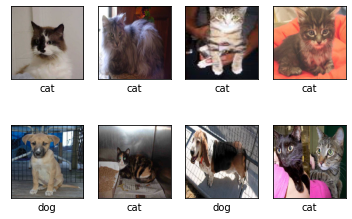

In [7]:
classes = ['cat', 'dog']

#plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_batch[i], cmap=plt.cm.binary)
    plt.xlabel(classes[int(label_batch[i])])
plt.show()


### create the model
create the model using ResNet50 with input (224x224x3). The top layers are omitted include_top=False) since we are going to use our own top layer, and all the internal layers are frozen beacause we use the weights ptretrained on ImageNet

In [8]:
base_model = tf.keras.applications.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)
)

base_model.trainable = False
base_model.summary()


4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0

### features batch
ResNet50 transforms each 224x224x3 image into 7x7x2048 block of features.

In [9]:
feature_batch = base_model(image_batch)
print("feature batch shape: ", feature_batch.shape)

feature batch shape:  (8, 7, 7, 2048)


### create the pooling layer
now, we can use `GlobalAveragePooling2D()` to average over the spatial 7x7 spatial locations and obtain a size of (8, 2048)

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print("feature batch average shape: ", feature_batch_average.shape)

feature batch average shape:  (8, 2048)


### create the last layer (dense)

In [11]:
prediction_layer = tf.keras.layers.Dense(units=1)
prediction_batch = prediction_layer(feature_batch_average)
print("prediction batch shape: ", prediction_batch.shape)

prediction batch shape:  (8, 1)


### compose the final model
compose the final model by combining the `base_model` (pretrained ResNet50) with `global_average_layer` to get the correct shape output given as an input to the final `prediction_layer`

In [12]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


### compile the model

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

### evaluate the current model

In [14]:
#loss0, accuracy0 = model.evaluate(testing_data)

### train the model

In [15]:
history = model.fit_generator(                        
                        training_data,
                        steps_per_epoch=32,
                        epochs = 10,
                        validation_data = testing_data)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
32/32 [==============================] - 272s 8s/step - loss: 7.6818 - acc: 0.4922 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 2/10
32/32 [==============================] - 259s 8s/step - loss: 8.1458 - acc: 0.4688 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 3/10
32/32 [==============================] - 259s 8s/step - loss: 7.2474 - acc: 0.5273 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 4/10
32/32 [==============================] - 264s 8s/step - loss: 7.3072 - acc: 0.5234 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 5/10
32/32 [==============================] - 259s 8s/step - loss: 8.5651 - acc: 0.4414 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 6/10
32/32 [==============================] - 258s 8s/step - loss: 7.1276 - acc: 0.5352 - val_loss: 7.6246 - val_acc: 0.5000
Epoch 7/10
32/32 [==============================] - 258s 8s/step - loss: 7.7265 - acc: 0.4961 - val_loss: 7.6246 - val_a

In [16]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,acc,val_loss,val_acc,epoch
5,7.127560,0.535156,7.624619,0.5,5
6,7.726515,0.496094,7.624619,0.5,6
7,7.666620,0.500000,7.624619,0.5,7
8,7.427038,0.515625,7.624619,0.5,8
9,7.846306,0.488281,7.624619,0.5,9


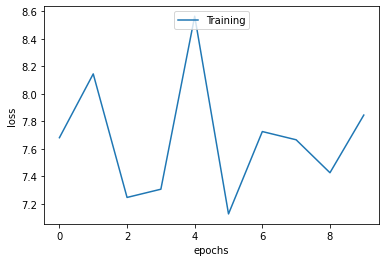

In [17]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history_df['epoch'], history_df['loss'], label='Training')
plt.legend(loc='upper center', shadow=False)

In [18]:
loss0, accuracy0 = model.evaluate(testing_data)

250/250 [==============================] - 225s 900ms/step - loss: 7.6246 - acc: 0.5000
